# 2. Εργαστηριακό μέρος

## Μέρος Α : Υλοποίηση αλγορίθμου

In [9]:
import urllib.request
import cv2
import scipy
import skimage
from skimage import data
from scipy.signal import convolve2d
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Φόρτωση των images Lena, Camera:

In [10]:
#fetch Lena image
HTTP_response = urllib.request.urlopen('http://www.image.ntua.gr/~tpar/LABimage/lena.png')


In [11]:
arr = np.asarray(bytearray(HTTP_response.read()), dtype=np.uint8)
BGR = cv2.imdecode(arr,-1)

Text(0.5, 1.0, 'Lena, grayscale')

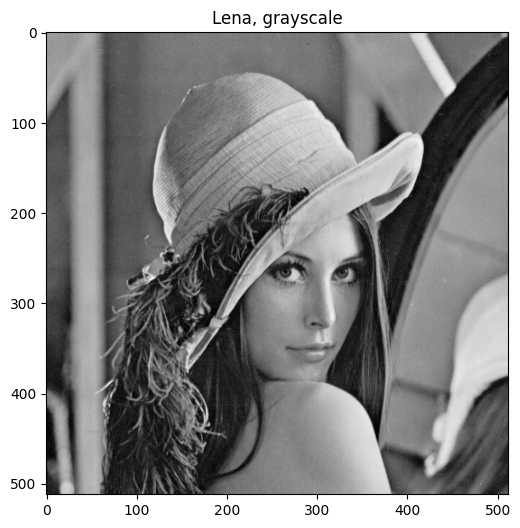

In [12]:
#convert to gray
Lena_gray = cv2.cvtColor(BGR, cv2.COLOR_BGR2YCrCb)[:,:,0]
plt.figure(figsize=(6, 6))
plt.imshow(Lena_gray, cmap="gray")
plt.title('Lena, grayscale')

Text(0.5, 1.0, 'Lena, RGB')

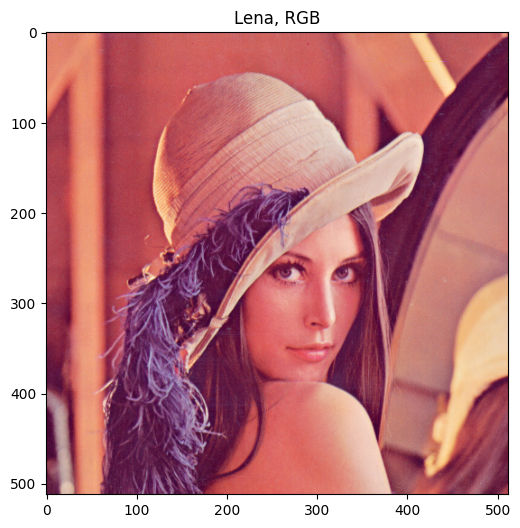

In [13]:
#keep with color, convert to RGB
Lena_RGB = cv2.cvtColor(BGR, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(Lena_RGB)
plt.title('Lena, RGB')

Text(0.5, 1.0, 'Camera, grayscale')

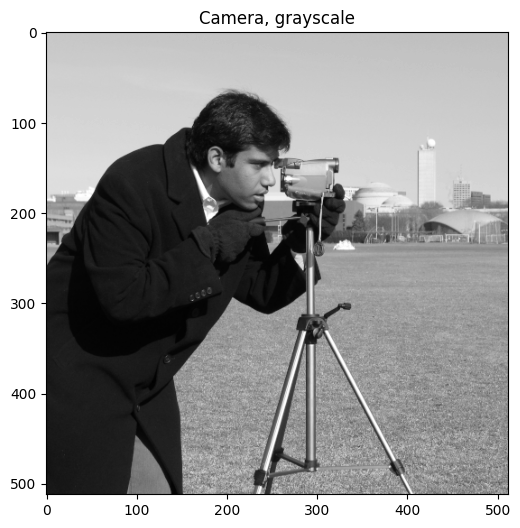

In [14]:
Camera=skimage.data.camera()
#BGR = cv2.imdecode(cam,-1)
#Camera = cv2.cvtColor(cam, cv2.COLOR_BGR2YCrCb)[:,:,0]
plt.figure(figsize=(6, 6))
plt.imshow(Camera, cmap="gray")
plt.title('Camera, grayscale')

Helper function

In [15]:
#helper function for printing a pyramid
def showPyramid(pyramid, case):
    if (case=='gray'):                                                                        #grayscale image
        f, ax = plt.subplots(1, len(pyramid), figsize=(20, 20))  
        for i in range (0,len(pyramid)):
            ax[i].imshow(pyramid[i], cmap="gray") # Base of the pyramid
            ax[i].set_title('Level {}'.format(i), fontsize=14)
    else:
        f, ax = plt.subplots(1, len(pyramid), figsize=(20, 20))                               #image with color
        for i in range (0,len(pyramid)):
            ax[i].imshow(pyramid[i].astype(int)) # Base of the pyramid
            ax[i].set_title('Level {}'.format(i), fontsize=14)

**Ερώτημα α):**

In [16]:
def GKernel(a):
  w = np.array([0.25 - a/2.0, 0.25, a, 0.25, 0.25 - a/2.0])                                   #1D kernel
  return w*w.reshape(-1,1)   

**Ερώτημα β):**

In [17]:
def GREDUCE(I,h):
  reduced_downsampled = None
  low_pass_image = cv2.filter2D(I,-1,h)                                                        #convolve image with generating kernel
  reduced_downsampled = low_pass_image[::2,::2]                                                #downsample lowpass image (sampling rate reduced in half)
  return reduced_downsampled

**Ερώτημα γ):** 

In [18]:
def GPyramid(I,a,depth):
  pyramid = [I]
  kernel = GKernel(0.4)
  for i in range(0,depth-1):
    gaussian_image = GREDUCE(pyramid[i],kernel)                                               #apply GREDUCE to image of previous level to get lowpass image of next level
    pyramid.append(gaussian_image)
  return pyramid

**Ερώτημα δ):**

In [19]:
def GEXPAND(I,h):
  expanded_image = None
  if (len(I.shape)==2):                                                                       #grayscale image
    tmp_image = np.zeros((I.shape[0]*2, I.shape[1]*2), dtype=np.float64)                      #obtain an array with every other pixel same as initial image, the rest of the pixels zero,
    tmp_image[::2,::2]=I                                                                      #will be used later for the interpolation of new node values between given values
  else:                                                                                       #image with color
    tmp_image = np.zeros((I.shape[0]*2, I.shape[1]*2, I.shape[2]), dtype=np.float64)
    tmp_image[::2,::2,:]=I
    expanded_image=np.zeros((I.shape[0]*2, I.shape[1]*2, I.shape[2]), dtype=np.float64)
  expanded_image = 4*cv2.filter2D(tmp_image,-1,h)                                             #equation (2) of paper
  return expanded_image

**Ερώτημα ε):**

In [20]:
def LPyramid(I,a,depth):
  gaussian_pyramid = GPyramid(I,a,depth)
  laplacian_pyramid = []
  kernel = GKernel(a)                                                                       #obtain generating kernel for the given value of a
  for i in range(0,depth-1):
    gaussian_image = gaussian_pyramid[i]
    expanded_gaussian_image = GEXPAND(gaussian_pyramid[i+1],kernel)                         #EXPAND image of each level to get the same dimensions as the previous level
    laplacian_pyramid.append(gaussian_image - expanded_gaussian_image+128)                  #get difference of images, add 128 so that we obtain only positive values (center around 128, not zero, this will be substracted 
                                                                                            #during deconstruction so it does not affect results, needed for prinintg the image)
  laplacian_pyramid.append(gaussian_pyramid[depth-1])
  return laplacian_pyramid

**Ερώτημα στ):**

In [21]:
def L_Pyramid_Decode(L,a):
    kernel = GKernel(a)
    sum_image=L[len(L)-1]
    for i in range(len(L)-2, -1, -1):
        expanded_image = GEXPAND(sum_image,kernel)                                          #expand image to obtain dimensions same as the previous level
        sum_image=L[i]+expanded_image-128                                                   #sum previous level to the sum image calculated so far
    return sum_image 

**Ερώτημα ζ):**

In [22]:
def L_Quantization(L,bins):                                                                 #Input parameters: the image to be quantized and the number of bins
    if (len(L.shape)==2):                                                                   #grayscale image
        C=np.zeros((L.shape[0], L.shape[1]), dtype=np.float64)
        max_val=L.max()
        n=256/bins                                                                          #maximum value is 255 (so 256 integer values: 0...255), calculate bin size for n bins
        for i in range (0,L.shape[0]):                                                      #for each pixel
            for j in range(0,L.shape[1]):
                for m in range(0,bins):
                    if (L[i][j]<=(m+1/2)*n and L[i][j]>=(m-1/2)*n):                         #equation (5) of paper
                        C[i][j]=m*n
    else:                                                                                   #image with color
        C=np.zeros((L.shape[0], L.shape[1],L.shape[2]), dtype=np.float64)
        max_val=L.max()
        n=255/bins                                                                          #maximum value is 255, calculate bin size for n bins
        for i in range (0,L.shape[0]):                                                      #for each pixel
            for j in range(0,L.shape[1]):
                for k in range(0,L.shape[2]):
                    for m in range(0,bins):
                        if (L[i][j][k]<=(m+1/2)*n and L[i][j][k]>=(m-1/2)*n):               #equation (5) of paper
                            C[i][j][k]=m*n
    return C

## Μέρος Β : Δοκιμές αλγορίθμου

Παρουσιάζουμε τις Gaussian πυραμίδες που πρκύπτουν, για τις εικόνες Lena (grayscale, RGB), και Camera:

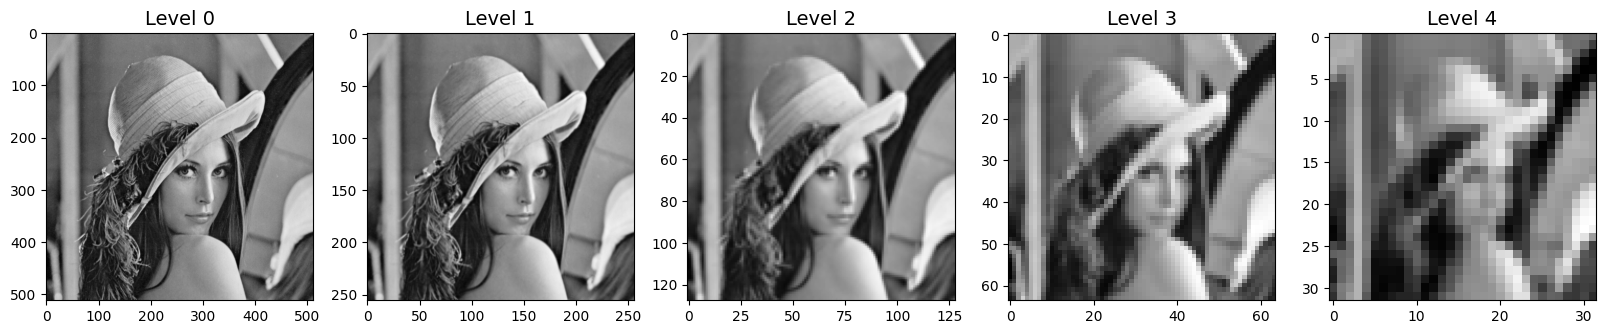

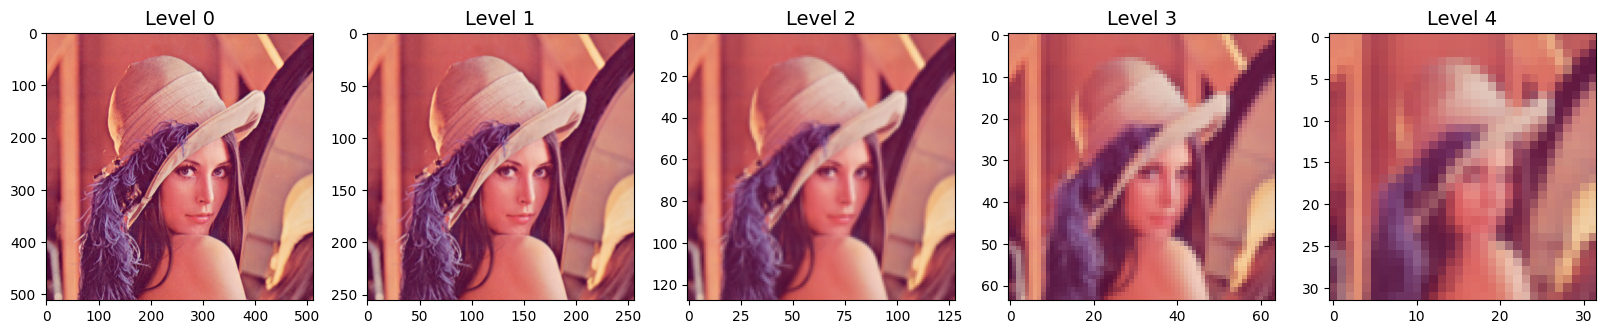

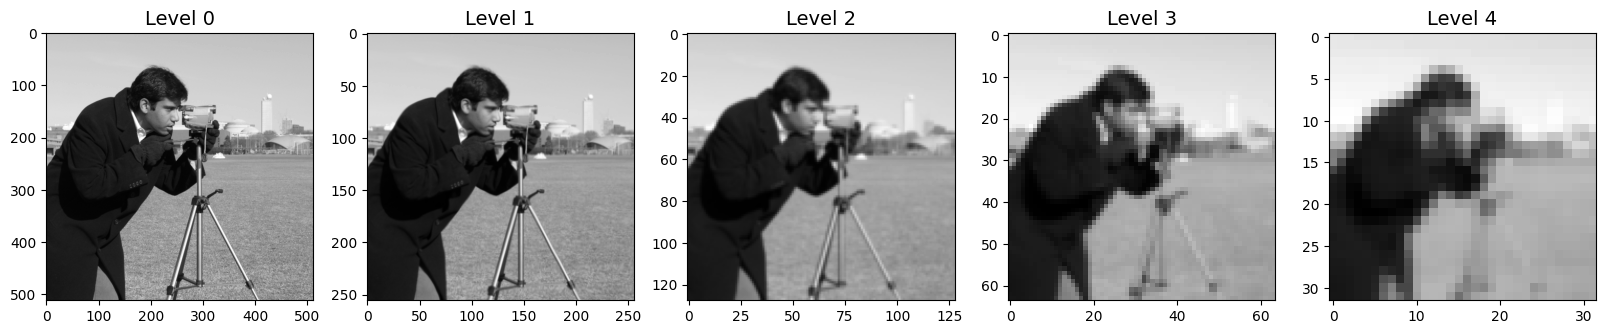

In [23]:
#calculate and print gaussian pyramid for each image 

#Lena grayscale
Lena_gray_gaus=GPyramid(Lena_gray,0.4,5)
#print(len(Lena_gray_gaus))
showPyramid(Lena_gray_gaus,'gray')

#Lena RGB

Lena_RGB_gaus=GPyramid(Lena_RGB,0.4,5)
showPyramid(Lena_RGB_gaus,'gray')

#Camera

Camera_gaus=GPyramid(Camera,0.4,5)
showPyramid(Camera_gaus,'gray')

Κάθε επίπεδο αποτελεί ένα βαθυπερατό τμήμα του προηγούμενου επιπέδου. Όσο προχωράμε σε επόμενα επίπεδα η εικόνα γίνεται πιο θολή (λιγότερο crisp).

**Ερώτημα α):**

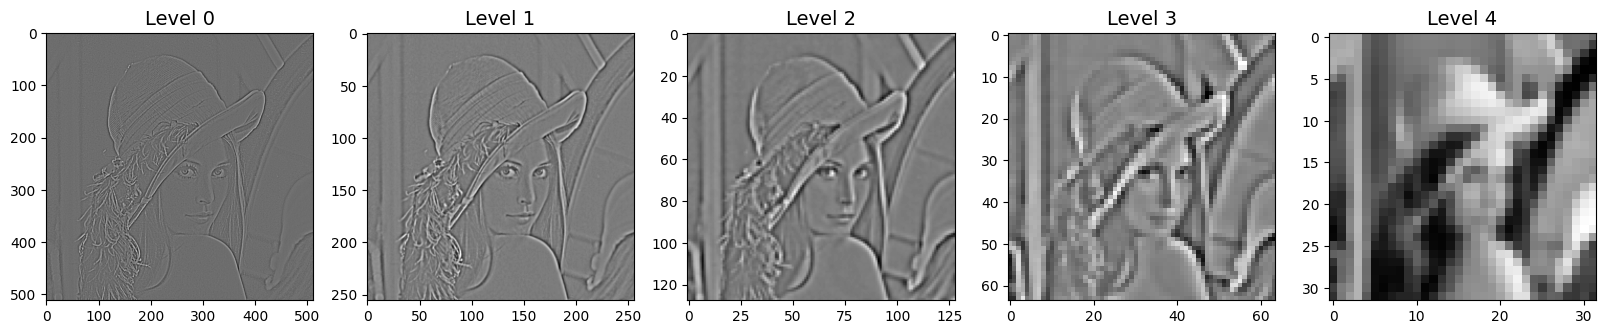

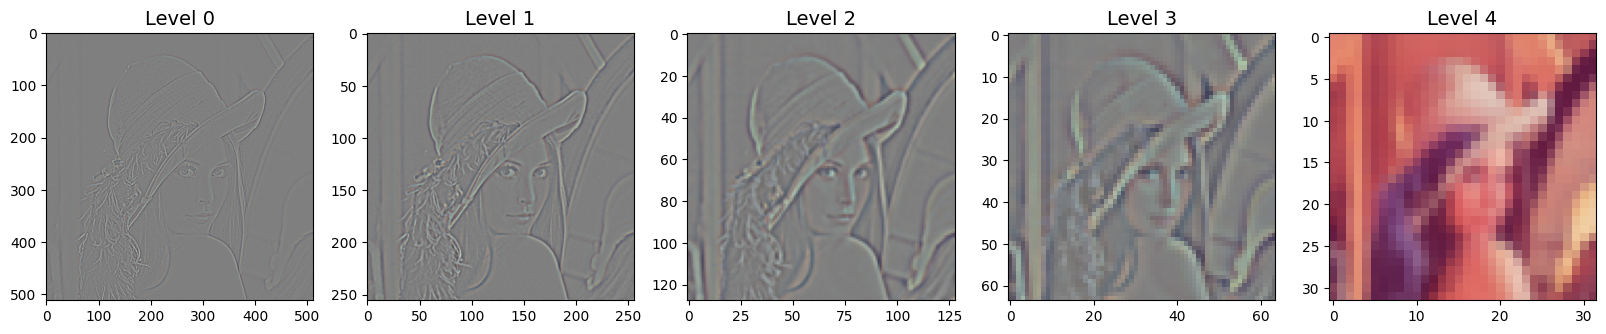

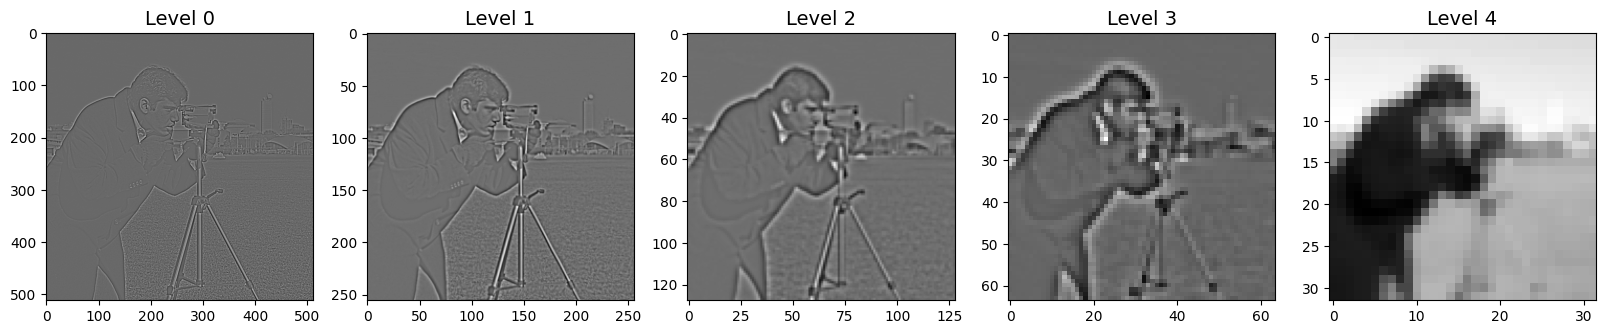

In [24]:
#Laplacian Pyramid

#Lena grayscale
Lena_gray_lap=LPyramid(Lena_gray,3/8,5)
showPyramid(Lena_gray_lap, 'gray')

#Lena RGB

Lena_RGB_lap=LPyramid(Lena_RGB,3/8,5)
showPyramid(Lena_RGB_lap,'RGB')

#Camera

Camera_lap=LPyramid(Camera,3/8,5)
showPyramid(Camera_lap,'gray')

Παρατηρούμε ότι στις εικόνες της Laplacian πυραμίδας εμφανίζονται έντονα οι λεπτομέρειες της εικόνας όπως για παράδειγμα οι ακμές αυτής. Οι πιο fine λεπτομέρειες είναι ορατές σε χαμηλότερα επίπεδα, ενώ όσο προχωράμε σε επόμενα επίπεδα βλέπουμε πιο coarse χαρακτηρηστικά. Αυτό συμβαίνει αφού ουσιαστικά κάθε επίπεδο προκύπτει ως η λεπτομέρεια μιας εικόνας με όλο και πιο βαθυπερατό φάσμα στην Gaussian πυραμίδα.

Στην συνέχεια παρουσιάζουμε την ανακατασευασμένη από την Laplacian πυραμίδα εικόνα, καθώς και την αρχική εικόνα

Text(0.5, 1.0, 'Original')

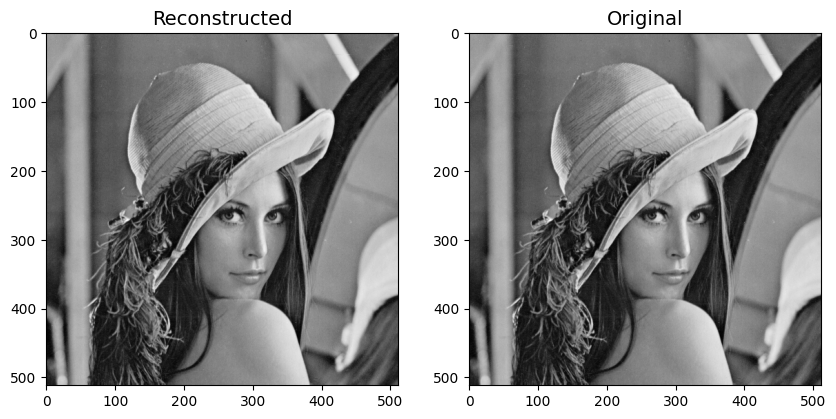

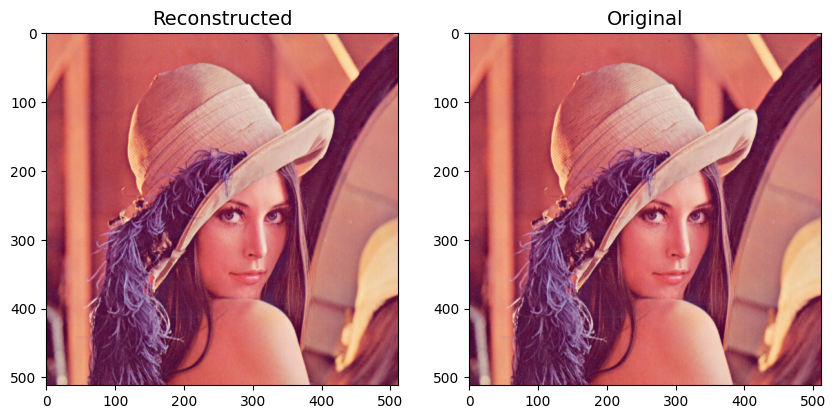

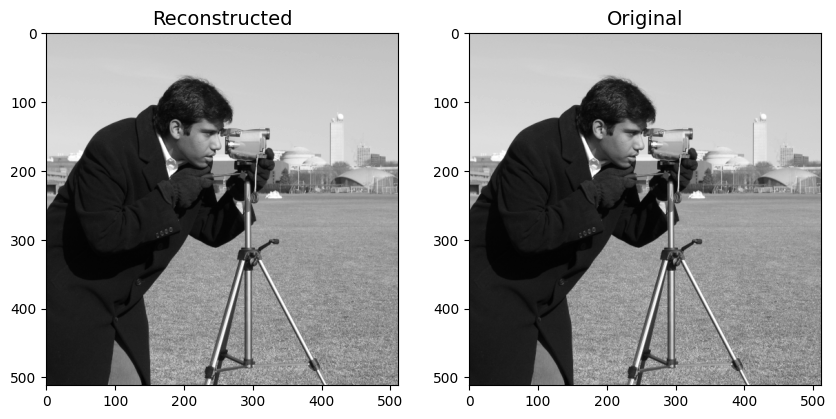

In [25]:
#Plot reconstructed images 

#Lena grayscale
Lena_gray_dec=L_Pyramid_Decode(Lena_gray_lap,3/8)
f1, (ax0,ax1)= plt.subplots(1, 2, figsize=(10, 10))

ax0.imshow(Lena_gray_dec, cmap="gray")
ax0.set_title('Reconstructed', fontsize=14)
ax1.imshow(Lena_gray, cmap="gray")
ax1.set_title('Original', fontsize=14)

#Lena RGB

Lena_RGB_dec=L_Pyramid_Decode(Lena_RGB_lap,3/8)
f2, (ax0,ax1)= plt.subplots(1, 2, figsize=(10, 10))
ax0.imshow(Lena_RGB_dec.astype(int), cmap="gray")
ax0.set_title('Reconstructed', fontsize=14)
ax1.imshow(Lena_RGB, cmap="gray")
ax1.set_title('Original', fontsize=14)

#Camera

Camera_dec=L_Pyramid_Decode(Camera_lap,3/8)
f3, (ax0,ax1)= plt.subplots(1, 2, figsize=(10, 10))
ax0.imshow(Camera_dec, cmap="gray")
ax0.set_title('Reconstructed', fontsize=14)
ax1.imshow(Camera, cmap="gray")
ax1.set_title('Original', fontsize=14)

In [26]:
# Check if the reconstruction is lossless

print('Is reconstruction exact for Lena grayscale?', (Lena_gray==Lena_gray_dec).all())
print('Is reconstruction exact for Lena RGB?',(Lena_RGB==Lena_RGB_dec).all())
print('Is reconstruction exact for Camera?',(Camera==Camera_dec).all())

Is reconstruction exact for Lena grayscale? True
Is reconstruction exact for Lena RGB? True
Is reconstruction exact for Camera? True


Παρατηρούμε ότι η ανακατασκευή της εικόνας από την Laplacian πυραμίδα γίνεται χωρίς απώλειες, κάτι το οποίο είναι αναμενόμενο σύμφωνα με την θεωρητική ανάλυση. (Προϋπόθεση αποτελεί ότι χρησισμοποιούμε κατά την κωδικοποίηση και κατά την αποκωδικοποίηση την ίδια τιμή για την παράμετρο a, στην παρούσα περίπτωση ίση με 3/8, ώστε να έχουμε το ίδιο generating kernel).